In [2]:
from fastai.vision.all import *

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision.widgets import FileUpload, ImageClassifierCleaner
sns.__version__


'0.11.1'

In [32]:
path = Path.cwd()/'../datasets/Tomato_leaf'

In [33]:
tomato_leaf = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    item_tfms=Resize(400),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.3, seed=42)
)

In [34]:
dls = tomato_leaf.dataloaders(path)

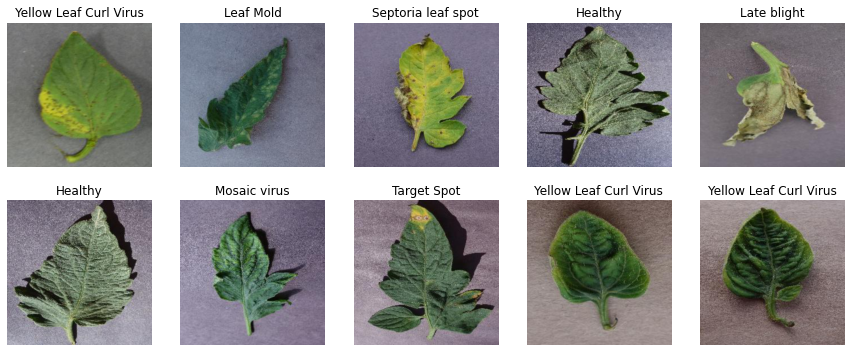

In [35]:
dls.train.show_batch(max_n=10, nrows=2)

In [36]:
model = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

In [37]:
model.fine_tune(15)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.476153,0.170146,0.058370,0.941630,05:06


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.130431,0.058378,0.018722,0.981278,06:50
1,0.050421,0.060729,0.019824,0.980176,06:50
2,0.051940,0.115938,0.029736,0.970264,06:51
3,0.055582,0.052002,0.016520,0.983480,06:51
4,0.037268,0.076360,0.022026,0.977974,06:50
5,0.039719,0.049345,0.014317,0.985683,06:50
6,0.020819,0.056036,0.016153,0.983847,06:51
7,0.025289,0.034132,0.010279,0.989721,06:50
8,0.014091,0.020133,0.006057,0.993943,06:50
9,0.010450,0.026399,0.007709,0.992291,06:50


In [39]:
interp = ClassificationInterpretation.from_learner(model)

In [82]:
df = pd.DataFrame(data=interp.confusion_matrix(), columns=model.dls.vocab)
df.style.set_properties().background_gradient('YlGnBu')

,Bacterial spot,Early blight,Healthy,Late blight,Leaf Mold,Mosaic virus,Septoria leaf spot,Spider mites,Target Spot,Yellow Leaf Curl Virus
0,633,0,0,0,0,0,0,0,0,0
1,0,281,0,2,0,0,0,0,1,0
2,0,0,472,0,0,0,0,0,0,0
3,0,3,0,571,1,0,0,0,0,0
4,0,0,0,1,313,0,0,0,0,0
5,0,0,0,0,0,129,0,0,0,0
6,0,0,0,1,0,0,525,0,0,0
7,0,0,0,0,0,0,0,476,1,0
8,1,1,0,0,0,0,0,4,418,0
9,0,0,0,0,0,0,0,0,0,1614


In [70]:
path = Path.cwd()/'../models/tomato.pkl'
model.export(path)

In [15]:
learner = load_learner(Path.cwd()/'../models/tomato.pkl')
btn_upload = FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [23]:
learner.predict(btn_upload.data[0])

('Septoria leaf spot',
 tensor(6),
 tensor([1.3705e-06, 3.0255e-01, 2.2390e-04, 1.7374e-01, 1.6155e-01, 3.0076e-04,
         3.6162e-01, 3.1247e-06, 8.5205e-07, 4.6981e-07]))

In [79]:
model.dls.vocab

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']